# Visualizing Goodreads User Library  - Team 8 project.

The processbook generates visual representation to a user's library as it was exported from Goodreads, using.

You can use it with your own data - go [here](https://www.goodreads.com/review/import) and press "Export your library" to get your own csv.
    
to get the interactive version. Replace the path to my Goodreads exported file by yours in the ipynb file or over-write over the CSV with the same file name.

### Python packages

* seaborn
* pandas
* wordcloud
* nltk
* distance
* image (PIL inside python for some weird reason)
* gender_guesser
* rpy2

To install all:

    pip install requirements.txt

OK, let's start!

## Setting up the notebook

In [59]:
%pylab inline

# for most plots
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict, Counter, OrderedDict

# for stats
import scipy.stats

# for time-related plots
import datetime
import calendar

# for word cloud
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud

sns.set_palette("coolwarm")

# for plotting images
from IPython.display import Image

# for gender guessing
import gender_guesser.detector as gender

# for R
import pandas
from rpy2 import robjects

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

Populating the interactive namespace from numpy and matplotlib


## Loading the data

In [60]:
df = pd.read_csv('./goodreads_export.csv')
# keep only books that have a rating (unrated books have a rating of 0, we don't need that)
cleaned_df = df[df["My Rating"] != 0]

# get rid of noise in 2012
cleaned_df = cleaned_df[(cleaned_df['Date Added'] > '2013-01-01')]

# Score distribution
With a score scale of 1-5, you'd expect that the average score is ~~2.5~~ 3 (since 0 is not counted) after a few hundred books (in other words, is it a normal distribution?)

('Average: 3.53', 'Median: 4.0')

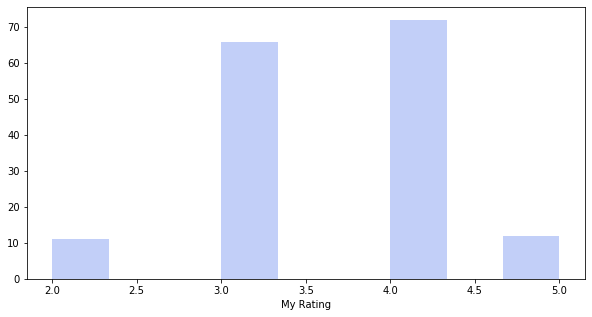

In [61]:
g = sns.distplot(cleaned_df["My Rating"], kde=False)
"Average: %.2f"%cleaned_df["My Rating"].mean(), "Median: %s"%cleaned_df["My Rating"].median()

That doesn't look normally distributed to me - let's ask Shapiro-Wilk (null hypothesis: data is drawn from normal distribution):

In [62]:
W, p_value = scipy.stats.shapiro(cleaned_df["My Rating"])
if p_value < 0.05:
    print("Rejecting null hypothesis - data does not come from a normal distribution (p=%s)"%p_value)
else:
    print("Cannot reject null hypothesis (p=%s)"%p_value)

Rejecting null hypothesis - data does not come from a normal distribution (p=6.528215901885348e-12)


In my case, the data is not normally distributed (in other words, the book scores are not evenly distributed around the middle). If you think about it, this makes sense: most readers don't read perfectly randomly, I avoid books I believe I'd dislike, and choose books that I prefer. I rate those books higher than average, therefore, my curve of scores is slanted towards the right.

## plot Pages vs Ratings

Are longer books given a better scores? A minor tendency but nothing special (it's confounded by having just 5 possible numbers in ratings)

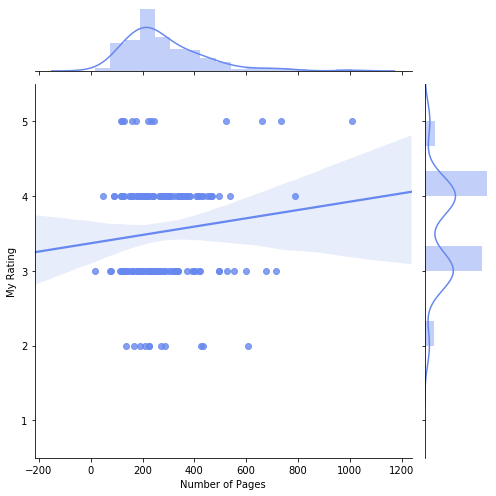

In [63]:
g = sns.jointplot("Number of Pages", "My Rating", data=cleaned_df, kind="reg", height=7, ylim=[0.5,5.5])

I seem to mostly read books at around 200 to 300 pages so it's hard to tell whether I give longer books better ratings. It's also a nice example that in regards to linear regression, a p-value as tiny as this one doesn't mean much, the r-value is still bad.

***

## plot Ratings vs Bookshelves

Let's parse ratings for books and make a violin plot for the 6 categories with the most rated books!

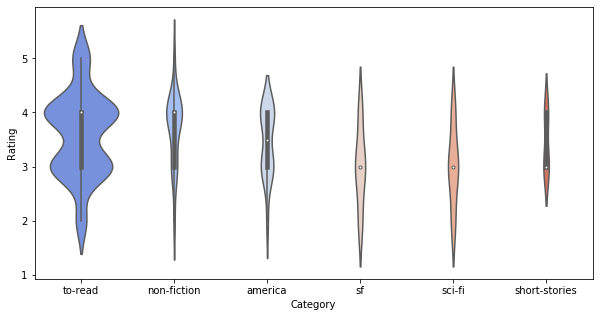

In [64]:
CATEGORIES = 6 # number of most crowded categories to plot

# we have to fiddle a bit - we have to count the ratings by category, 
# since each book can have several comma-delimited categories
# TODO: find a pandas-like way to do this

shelves_ratings = defaultdict(list) # key: shelf-name, value: list of ratings
shelves_counter = Counter() # counts how many books on each shelf
shelves_to_names = defaultdict(list) # key: shelf-name, value: list of book names
for index, row in cleaned_df.iterrows():
    my_rating = row["My Rating"]
    if my_rating == 0:
        continue
    if pd.isnull(row["Bookshelves"]):
        continue

    shelves = row["Bookshelves"].split(",")

    for s in shelves:
        # empty shelf?
        if not s: continue
        s = s.strip() # I had "non-fiction" and " non-fiction"
        shelves_ratings[s].append(my_rating)
        shelves_counter[s] += 10
        shelves_to_names[s].append(row.Title)

names = []
ratings = []
for name, _ in shelves_counter.most_common(CATEGORIES):
    for number in shelves_ratings[name]:
        names.append(name)
        ratings.append(number)

full_table = pd.DataFrame({"Category":names, "Rating":ratings})

# if we don't use scale=count here then each violin has the same area
sns.violinplot(x = "Category", y = "Rating", data=full_table, scale='count')

There is some *bad* SF out there!

## plotHistogramDistanceRead.py

Let's check the "dates read" for each book read and plot the distance between books read in days - shows you how quickly you hop from book to book.

I didn't use Goodreads in 2012 much so let's see how it looks like without 2012:

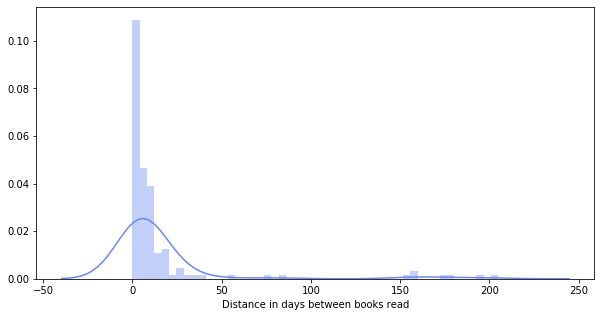

In [65]:
# first, transform to datetype and get rid of all invalid dates
#dates = pd.to_datetime(cleaned_df["Date Read"])
dates = pd.to_datetime(cleaned_df["Date Added"])

dates = dates.dropna()
sorted_dates = sorted(dates)

last_date = None
differences = []
all_days = []
all_days_without_2012 = [] # not much goodreads usage in 2012 - remove that year
for date in sorted_dates:
    if not last_date:
        last_date = date
        if date.year != 2012:
            last_date_not_2012 = date
    difference = date - last_date
    
    days = difference.days
    all_days.append(days)
    if date.year != 2012:
        all_days_without_2012.append(days)
    last_date = date

sns.distplot(all_days_without_2012, axlabel="Distance in days between books read")
pylab.show()

***

## plot Heatmap of dates read

Parses the "dates read" for each book read, bins them by month, and makes a heatmap to show in which months I read more than in others. Also makes a lineplot for books read, split up by year.

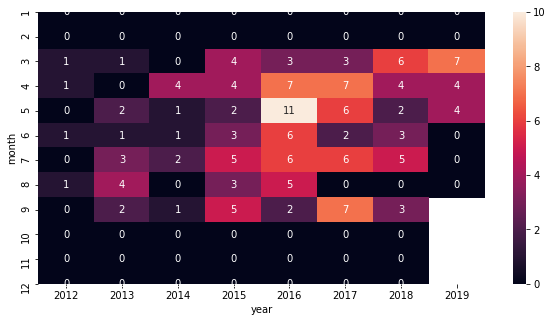

In [66]:
# we need a dataframe in this format:
# year months books_read
# I am sure there's some magic pandas function for this

read_dict = defaultdict(int) # key: (year, month), value: count of books read
for date in sorted_dates:
    this_year = date.year
    this_month = date.month
    read_dict[ (this_year, this_month) ] += 1

first_date = sorted_dates[0]

first_year = first_date.year
first_month = first_date.month

todays_date = datetime.datetime.today()
todays_year = todays_date.year
todays_month = todays_date.month

all_years = []
all_months = []
all_counts = []
for year in range(first_year, todays_year+1):
    for month in range(1, 13):
        if (year == todays_year) and month > todays_month:
            # don't count future months
            # it's 2015-12 now so a bit hard to test
            break
        this_count = read_dict[ (year, month) ]
        all_years.append(year)
        all_months.append(month)
        all_counts.append(this_count)

# now get it in the format heatmap() wants
df = pd.DataFrame( { "month":all_months, "year":all_years, "books_read":all_counts } )
dfp = df.pivot("month", "year", "books_read")

# now make the heatmap
ax = sns.heatmap(dfp, annot=True, vmin=0, vmax=10)

What happened in May 2016?

***
## Plot books read by year

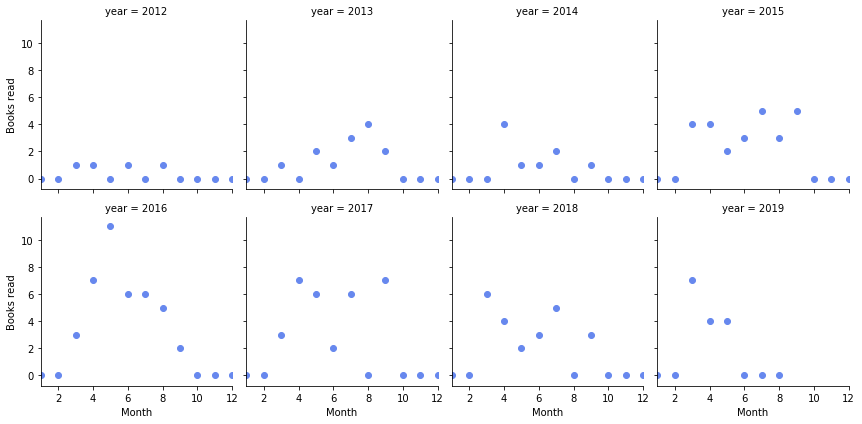

In [67]:
g = sns.FacetGrid(df, col="year", sharey=True, sharex=True, col_wrap=4)
g.map(plt.scatter, "month", "books_read")
g.set_ylabels("Books read")
g.set_xlabels("Month")
pylab.xlim(1, 12)
pylab.show()

It's nice how reading behaviour (Goodreads usage) connects over the months - it's slowly up until 2014, stays about constant from 2015-2017, and now goes down again.

***

## Guessing authors' genders

Let's check whether I read mostly male or female authors using the gender-guesser package!

In [83]:
first_names = cleaned_df['Author'].str.split(' ',expand=True)[0]
d = gender.Detector(case_sensitive=False)

genders = [d.get_gender(name) for name in first_names]
print(list(zip(genders[:5], first_names[:5])))
# let's also add those few 'mostly_female' and 'mostly_male' into the main group
genders = pd.Series([x.replace('mostly_female','female').replace('mostly_male','male') for x in genders])

[('male', 'Adrian'), ('male', 'Stephen'), ('unknown', 'Ocean'), ('mostly_female', 'Tracy'), ('male', 'Ezra')]


male       117
unknown     23
female      19
andy         2
dtype: int64


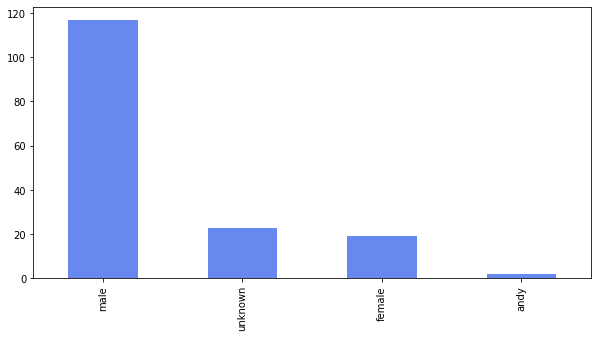

In [84]:
gender_ratios = genders.value_counts()
print(gender_ratios)
_ = gender_ratios.plot(kind='bar')

Now THAT'S gender bias. Do I rate the genders differently?

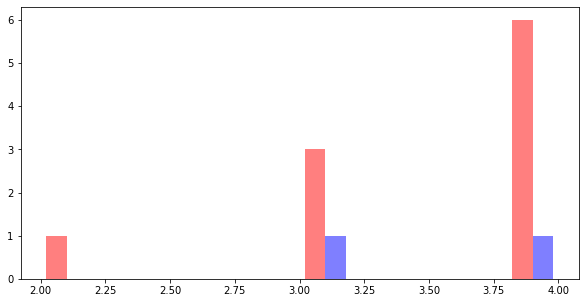

In [70]:
cleaned_df['Gender'] = genders

male_scores = cleaned_df[cleaned_df['Gender'] == 'male']['My Rating'].values
female_scores = cleaned_df[cleaned_df['Gender'] == 'female']['My Rating'].values

_ = plt.hist([male_scores, female_scores], color=['r','b'], alpha=0.5)

Hard to tell any difference since there are so fewer women authors here - let's split them up into different plots

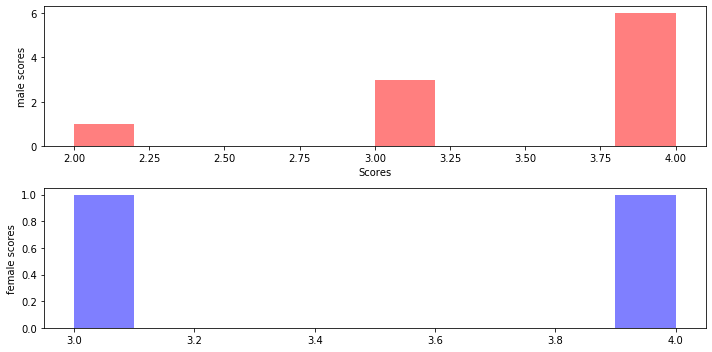

In [71]:
fig, axes = plt.subplots(2,1)

axes[0].hist(male_scores, color='r', alpha=0.5, bins=10)
axes[0].set_xlabel('Scores')
# Make the y-axis label, ticks and tick labels match the line color.
axes[0].set_ylabel('male scores')

axes[1].hist(female_scores, color='b', alpha=0.5, bins=10)
axes[1].set_ylabel('female scores')

fig.tight_layout()

Are these two samples from the same distribution? Hard to tell since their size is so different.


***

## Compare with Goodreads 10k


A helpful soul has uploaded ratings and stats for the 10,000 books with most ratings on Goodreads (https://github.com/zygmuntz/goodbooks-10k). Let's compare those with my ratings!

In [73]:
other = pd.read_csv('./goodbooks-10k/books.csv')
print(other.columns)
other.head(3)

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url'],
      dtype='object')


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...


What's the gender ratio here?

male             4669
female           3424
unknown          1180
mostly_male       347
mostly_female     332
andy               48
dtype: int64


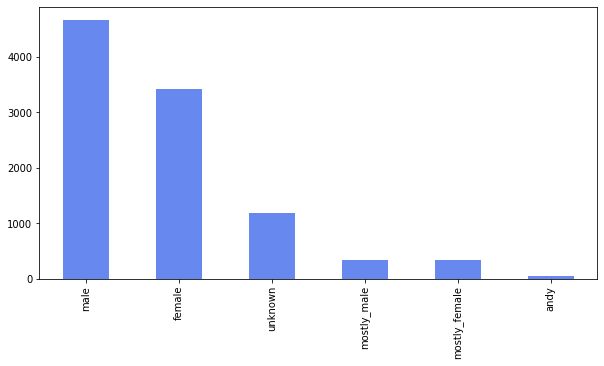

In [74]:

other_first_names = other.authors.str.split(' ',expand=True)[0]
for index, x in enumerate(other_first_names):
    if x == 'J.R.R.':
        other_first_names[index] = 'John'
    elif x == 'J.K.':
        other_first_names[index] = 'Joanne'
    elif x == 'F.':
        other_first_names[index] = 'Francis'
    elif x == 'C.S.':
        other_first_names[index] = 'Clive'
    elif x == 'J.D.':
        other_first_names[index] = 'Jerome'
        
other_genders = pd.Series([d.get_gender(name) for name in other_first_names])
gender_ratios = other_genders.value_counts()
print(gender_ratios)
_ = gender_ratios.plot(kind='bar')

other['Gender'] = other_genders

A bit better than my own reviews! I should multiply the authors with their numbers_read, then J. K. Rowling will probably blow everybody else out of the water

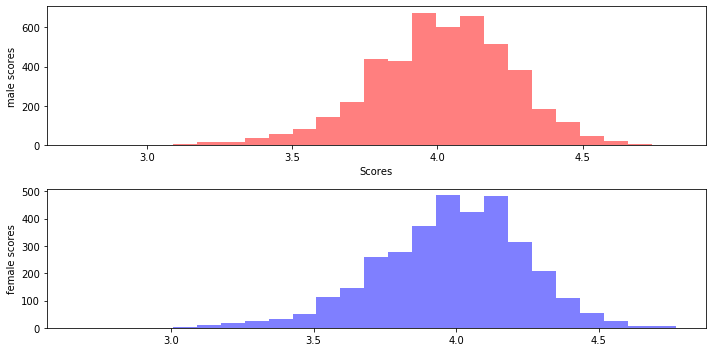

In [75]:
male_scores = other[other['Gender'] == 'male']['average_rating'].values
female_scores = other[other['Gender'] == 'female']['average_rating'].values

fig, axes = plt.subplots(2,1)

axes[0].hist(male_scores, color='r', alpha=0.5, bins=25)
axes[0].set_xlabel('Scores')
# Make the y-axis label, ticks and tick labels match the line color.
axes[0].set_ylabel('male scores')

axes[1].hist(female_scores, color='b', alpha=0.5, bins=25)
axes[1].set_ylabel('female scores')

fig.tight_layout()

Very similar, again, with a slight shift to the right in the 'female scores'

Is my 'Book Id' the same as the other's table 'goodreads_book_id'?

In [76]:
both = other.merge(cleaned_df, how='inner', left_on='goodreads_book_id', right_on='Book Id')
print('My reviews: %s, 10k Reviews: %s, Intersection: %s'%(cleaned_df.shape, other.shape, both.shape))

My reviews: (161, 32), 10k Reviews: (10000, 24), Intersection: (26, 56)


Looks good! Now check which is the most common and the most obscure book in my list

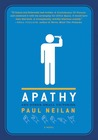

In [77]:
Image(both.sort_values(by='ratings_count').head(1).image_url.iloc[0])

Apathy, a wonderful book, you should read it!

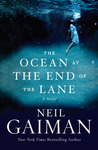

In [78]:
Image(both.sort_values(by='ratings_count').tail(1).image_url.iloc[0])

For which book does my rating have the highest difference in score?

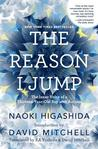

Book: The Lysenko Affair, My rating: 2 Global average rating: 3.81


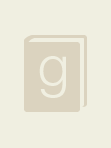

Book: The Library of Greek Mythology, My rating: 2 Global average rating: 4.01


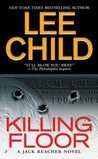

Book: Time for Research: Time Management for PhD Students, My rating: 2 Global average rating: 4.05


In [86]:
my_rating = cleaned_df['My Rating']
other_ratings = cleaned_df['Average Rating']
cleaned_df['Difference Rating'] = np.abs(my_rating - other_ratings)
ten_biggest_diff = cleaned_df.sort_values(by='Difference Rating').tail(10)

for x in ten_biggest_diff.iterrows():
    book_id = x[1]['Book Id']
    ten_thousand_books_info = other.where(other['goodreads_book_id'] == book_id).dropna()
    try:
        this_image_url = ten_thousand_books_info.image_url.iloc[0]
    except IndexError:
        # not found in big table
        continue
    display(Image(this_image_url))
    details = x[1]
    print('Book: %s, My rating: %s Global average rating: %s'%(details['Title'], details['My Rating'], details['Average Rating'] ))

Do I have many differences in how I rate my book when compared with the community?

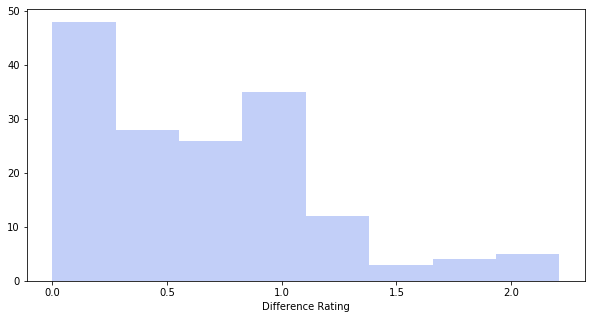

In [80]:
sns.distplot(cleaned_df['Difference Rating'], kde=False)

Not really, mostly 0 and 1 difference.

## plot Word Cloud


This one removes noisy words and creates a word-cloud of most commonly used words in the reviews.

You have 8581 words in 60 reviews


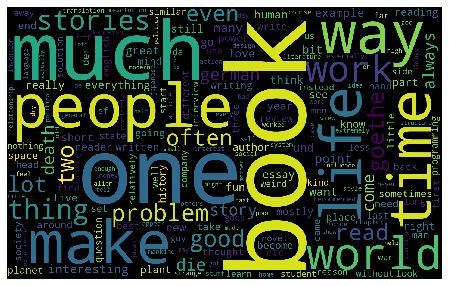

In [81]:
def replace_by_space(word):
    new = []
    for letter in word:
        if letter in REMOVE:
            new.append(' ')
        else:
            new.append(letter)
    return ''.join(new)

STOP = stopwords.words("english")
html_clean = re.compile('<.*?>')
gr_clean = re.compile('\[.*?\]')
PRINTABLE = string.printable
REMOVE = set(["!","(",")",":",".",";",",",'"',"?","-",">","_"])

all_my_words = []
all_my_words_with_stop_words = []

reviews = cleaned_df["My Review"]

num_reviews = 0
num_words = 0
for row in reviews:
    if pd.isnull(row):
        continue
    review = row.lower()
    if not review:
        # empty review
        continue
    # clean strings
    cleaned_review = re.sub(html_clean, '', review)
    cleaned_review = re.sub(gr_clean, '', cleaned_review)
    all_my_words_with_stop_words += cleaned_review
    cleaned_review = replace_by_space(cleaned_review)
    cleaned_review = "".join(filter(lambda x: x in PRINTABLE, cleaned_review))
    # clean words
    cleaned_review = cleaned_review.split()
    cleaned_review = list(filter(lambda x: x not in STOP, cleaned_review))
    num_words += len(cleaned_review)
    all_my_words += cleaned_review
    num_reviews += 1

print("You have %s words in %s reviews"%(num_words, num_reviews))

# WordCloud takes only string, no list/set
wordcloud = WordCloud(max_font_size=400, width=1600, height=1000).generate(' '.join(all_my_words))
pylab.imshow(wordcloud)
pylab.axis("off")
pylab.show()

***

## plot books read vs. week-day

Let's parse the weekday a "book read" has been added and count them

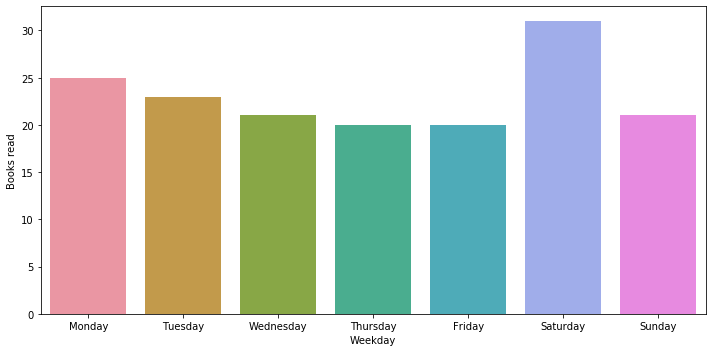

In [82]:
# initialize the dict in the correct order
read_dict = OrderedDict() # key: weekday, value: count of books read
for day in range(0,7):
    read_dict[calendar.day_name[day]] = 0

for date in sorted_dates:
    weekday_name = calendar.day_name[date.weekday()]  # Sunday
    read_dict[weekday_name] += 1

full_table = pd.DataFrame({"Weekday":list(read_dict.keys()), "Books read":list(read_dict.values())})

sns.barplot(x="Weekday", y="Books read", data=full_table)
plt.tight_layout()
plt.show()


Friday is procrastination day.